Rerun NATMI with outliers removed

In [1]:
library(Seurat)

library(dplyr)
library(tidyr)
library(stringr)
library(readxl)

library(ggplot2)
library(gridExtra)
library(ggpubr)
library(viridis)
library(ComplexHeatmap)
library(circlize)
library(ggrepel)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(

In [2]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS/LAPACK: /mnt/volume1/env/miniconda3/envs/r4.1.0/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.9.1        circlize_0.4.13      ComplexHeatmap_2.8.0
 [4] viridis_0.6.1        viridisLite_0.4.0    ggpubr_0.4.0        
 [7] gridExtra_2.3        ggplot2_3.3.5        readxl_1.3.1        
[10] stringr_1.4.0        tidyr_1.1.3          dplyr_1.0.7         
[13] SeuratObject_4.0.2   Seurat_4.0.3        

loaded via a namespace (

# Load data

In [3]:
sc <- readRDS("../data/dorDG2021outlierrem_seurat.RDS")

In [4]:
sc@meta.data %>% distinct(Treatment, MUXid) %>% group_by(Treatment) %>% tally()

Treatment,n
<chr>,<int>
FT,6
Sham,7


In [5]:
table(sc@meta.data$Treatment, sc@meta.data$MUXid)

      
       MUX6490 MUX6493 MUX6495 MUX6497 MUX6499 MUX6501 MUX6503 MUX6505 MUX6507
  FT         0     120       0      23       0      86       0      58       0
  Sham      98       0     132       0      52       0      30       0      97
      
       MUX6510 MUX6512 MUX6514 MUX6516
  FT         0     128       0      99
  Sham     119       0     115       0

In [6]:
table(sc@meta.data$IntSeuratSubCfinal, sc@meta.data$MUXid)

             
              MUX6490 MUX6493 MUX6495 MUX6497 MUX6499 MUX6501 MUX6503 MUX6505
  AstroSub1         4       6      21       4       1      10       4       6
  BergGlia          3       5       4       0       1      13       1       1
  Endothelial      17      20       9       4       0       0       0       0
  ExcitNeuron       0       2       6       1       0       4       0      22
  Granule           1       5       8       4       0       4       0      19
  InhibNeuron       1       7      46       7       0       5       0       0
  Microglia1       15      14       1       0      14       0       0       0
  Microglia2       13      18       1       0       6      10       1       7
  Mossy             5       9       4       2       4      15       1       2
  Oligodend1       11      10      28       0       7       0      16       0
  Oligodend2       12      11       0       0      17      13       1       0
  OPC              16      13       4       1     

Make NATMI input

In [6]:
makeNatmiInput <- function(mux_id){
    select <- (sc$MUXid == mux_id)
    sc.select <- sc[,select]

    cpm.select <- 100*(exp(as.matrix(
        GetAssayData(object = sc.select, assay = 'RNA', slot = 'data')
    )))

    write.csv(cpm.select, file = paste0(
        "../processed_data/211116_natmi_dorDG/", mux_id, ".csv"), 
        row.names = T, quote = F)

    cpm.meta <- sc.select@meta.data %>% select(IntSeuratSubCfinal) %>%
        tibble::rownames_to_column("barcode") %>%
        rename(c("annotation" = "IntSeuratSubCfinal"))

    write.csv(cpm.meta, file = paste0(
        "../processed_data/211116_natmi_dorDG/", mux_id, ".ann.csv"), 
        row.names = F, quote = F)    
}

lapply(unique(sc@meta.data$MUXid), makeNatmiInput)

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

Generate NATMI commands

In [7]:
base.path <- "../../workspace/AntidepressantVisium/processed_data/211116_natmi_dorDG/"
handle <- file("../processed_data/211116_natmi_dorDG/run_natmi.sh")

makeCmd <- function(mux_id){
    cmd <- paste("python", "ExtractEdges.py", 
        "--interDB", "lrc2p", 
        "--emFile", paste0(base.path, mux_id, ".csv"), 
        "--annFile", paste0(base.path, mux_id, ".ann.csv"), 
        "--coreNum", "4", 
        "--species", "rat",
        "--out", paste0(base.path, mux_id)
    )
    return(cmd)
}

cmds <- as.character(lapply(unique(sc@meta.data$MUXid), makeCmd))
writeLines(cmds, handle)
close(handle)

# Results

## Test difference

Read edges

In [8]:
readEdges <- function(mux_id){
    edges <- read.csv(paste0("../processed_data/211116_natmi_dorDG/", mux_id, "/Edges_lrc2p.csv"))
    edges$MUXid <- mux_id
    return(edges)
}

edges <- lapply(unique(sc@meta.data$MUXid), readEdges)
edges <- bind_rows(edges)

Test differences in expression or specificity weight

In [9]:
expr.weight <- edges %>%
    select(Sending.cluster, Ligand.symbol, Receptor.symbol, Target.cluster, Edge.average.expression.weight, MUXid) %>%
    pivot_wider(
        id_cols = c('Sending.cluster', 'Ligand.symbol', 'Receptor.symbol', 'Target.cluster'), 
        names_from = "MUXid", 
        values_from = "Edge.average.expression.weight"
    )
expr.weight %>% head()

Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,MUX6510,MUX6514,MUX6490,MUX6495,MUX6499,MUX6503,MUX6507,MUX6512,MUX6516,MUX6493,MUX6497,MUX6501,MUX6505
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AstroSub1,Agt,Mas1,AstroSub1,82683.02,253236.2,184942.7,48835.07,89201.65,10000,NA,175315.2,98692.82,181456.7,77744.44,124113.4,14485.11
AstroSub1,Agt,Mas1,BergGlia,272497.10,122080.1,184942.7,44012.62,89201.65,10000,NA,NA,88968.24,181456.7,NA,124113.4,193534.67
AstroSub1,Agt,Mas1,Endothelial,84851.76,122080.1,184942.7,44012.62,NA,NA,NA,175315.2,88968.24,181456.7,27882.69,NA,NA
AstroSub1,Agt,Mas1,ExcitNeuron,98424.97,122080.1,NA,44012.62,NA,NA,NA,NA,88968.24,181456.7,50735.48,161306.6,24060.05
AstroSub1,Agt,Mas1,Granule,82683.02,155255.8,184942.7,44012.62,NA,NA,NA,215603.6,88968.24,181456.7,27882.69,124113.4,40638.60
AstroSub1,Agt,Mas1,Microglia1,82683.02,122080.1,184942.7,44012.62,89201.65,NA,NA,175315.2,100644.32,181456.7,NA,NA,NA


In [10]:
ids_sham <- sc@meta.data %>% distinct(Treatment, MUXid) %>%
    filter(Treatment == 'Sham') %>% pull(MUXid) %>% as.character()
ids_ft <- sc@meta.data %>% distinct(Treatment, MUXid) %>%
    filter(Treatment == 'FT') %>% pull(MUXid) %>% as.character()

In [11]:
testDifference <- function(rowIdx){
    x.1 <- as.numeric(expr.weight[rowIdx, ids_ft])
    x.2 <- as.numeric(expr.weight[rowIdx, ids_sham])
    
    x.1[is.na(x.1)] <- 0
    x.2[is.na(x.2)] <- 0
    
    logmean.1 <- log1p(mean(x.1))
    logmean.2 <- log1p(mean(x.2))

    pval <- wilcox.test(x.1, x.2, exact = F)$p.value
    logfc = logmean.1 - logmean.2

    res <- tibble::as_tibble_row(c(
        'logmean.1' = logmean.1, 
        'logmean.2' = logmean.2, 
        'pval' = pval, 
        'logfc' = logfc
    ))
    return(res)
}

res <- do.call(rbind, lapply(c(1:dim(expr.weight)[1]), testDifference))
res <- cbind(expr.weight %>% dplyr::select(Sending.cluster, Ligand.symbol, Receptor.symbol, Target.cluster), res)
res %>% head()

,Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,logmean.1,logmean.2,pval,logfc
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,AstroSub1,Agt,Mas1,AstroSub1,11.62598,11.46749,0.6170751,0.15848880
2,AstroSub1,Agt,Mas1,BergGlia,11.49286,11.54490,0.9427417,-0.05203903
3,AstroSub1,Agt,Mas1,Endothelial,11.27642,11.03924,0.8255387,0.23717519
4,AstroSub1,Agt,Mas1,ExcitNeuron,11.34359,10.53978,0.2116336,0.80380570
5,AstroSub1,Agt,Mas1,Granule,11.63613,11.10796,0.2813175,0.52816711
6,AstroSub1,Agt,Mas1,Microglia1,11.24160,11.22129,0.9414276,0.02031556


In [12]:
write.csv(res, file = "../processed_data/211116_natmi_dorDG/expr_avg.csv")

In [13]:
spec.weight <- edges %>%
    select(Sending.cluster, Ligand.symbol, Receptor.symbol, Target.cluster, Edge.average.expression.derived.specificity, MUXid) %>%
    pivot_wider(
        id_cols = c('Sending.cluster', 'Ligand.symbol', 'Receptor.symbol', 'Target.cluster'), 
        names_from = "MUXid", 
        values_from = "Edge.average.expression.derived.specificity"
    )
spec.weight %>% head()

Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,MUX6510,MUX6514,MUX6490,MUX6495,MUX6499,MUX6503,MUX6507,MUX6512,MUX6516,MUX6493,MUX6497,MUX6501,MUX6505
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AstroSub1,Agt,Mas1,AstroSub1,0.02519138,0.04070732,0.03992661,0.02601820,0.06813956,0.01862921,NA,0.05694847,0.01986622,0.04075196,0.08882490,0.03748017,0.008256791
AstroSub1,Agt,Mas1,BergGlia,0.08302285,0.01962419,0.03992661,0.02344891,0.06813956,0.01862921,NA,NA,0.01790872,0.04075196,NA,0.03748017,0.110318484
AstroSub1,Agt,Mas1,Endothelial,0.02585215,0.01962419,0.03992661,0.02344891,NA,NA,NA,0.05694847,0.01790872,0.04075196,0.03185665,NA,NA
AstroSub1,Agt,Mas1,ExcitNeuron,0.02998755,0.01962419,NA,0.02344891,NA,NA,NA,NA,0.01790872,0.04075196,0.05796651,0.04871187,0.013714690
AstroSub1,Agt,Mas1,Granule,0.02519138,0.02495713,0.03992661,0.02344891,NA,NA,NA,0.07003556,0.01790872,0.04075196,0.03185665,0.03748017,0.023164784
AstroSub1,Agt,Mas1,Microglia1,0.02519138,0.01962419,0.03992661,0.02344891,0.06813956,NA,NA,0.05694847,0.02025904,0.04075196,NA,NA,NA


In [14]:
testDifference <- function(rowIdx){
    x.1 <- as.numeric(spec.weight[rowIdx, ids_ft])
    x.2 <- as.numeric(spec.weight[rowIdx, ids_sham])
    
    x.1[is.na(x.1)] <- 0
    x.2[is.na(x.2)] <- 0
    
    mean.1 <- mean(x.1)
    mean.2 <- mean(x.2)
    
    pval <- wilcox.test(x.1, x.2, exact = F)$p.value
    diff = mean.1 - mean.2
    
    res <- tibble::as_tibble_row(c(
        'mean.1' = mean.1, 
        'mean.2' = mean.2, 
        'pval' = pval, 
        'diff' = diff
    ))
    return(res)
}

res <- do.call(rbind, lapply(c(1:dim(spec.weight)[1]), testDifference))
res <- cbind(spec.weight %>% dplyr::select(Sending.cluster, Ligand.symbol, Receptor.symbol, Target.cluster), res)
res %>% head()

,Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,mean.1,mean.2,pval,diff
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,AstroSub1,Agt,Mas1,AstroSub1,0.04202142,0.03123033,0.5203168,0.010791091
2,AstroSub1,Agt,Mas1,BergGlia,0.03440989,0.03611305,0.7195042,-0.001703157
3,AstroSub1,Agt,Mas1,Endothelial,0.02457763,0.01555026,0.5084322,0.009027369
4,AstroSub1,Agt,Mas1,ExcitNeuron,0.02984229,0.01043723,0.1627032,0.019405057
5,AstroSub1,Agt,Mas1,Granule,0.03686631,0.01621772,0.1314751,0.020648587
6,AstroSub1,Agt,Mas1,Microglia1,0.01965991,0.02519009,0.7133369,-0.005530181


In [15]:
write.csv(res, file = "../processed_data/211116_natmi_dorDG/spec_avg.csv")

## Compile results

In [16]:
expr.res <- read.csv("../processed_data/211116_natmi_dorDG/expr_avg.csv")
spec.res <- read.csv("../processed_data/211116_natmi_dorDG/spec_avg.csv")

Get percent expressing

In [17]:
Idents(sc) <- paste0(sc@meta.data$MUXid, '%', sc@meta.data$IntSeuratSubCfinal)

In [18]:
lrs <- unique(c(
  expr.res %>% pull(Ligand.symbol), 
  expr.res %>% pull(Receptor.symbol), 
  spec.res %>% pull(Ligand.symbol), 
  spec.res %>% pull(Receptor.symbol)
))

dp <- DotPlot(sc, features = lrs)
dpd <- dp$data

pt_ct <- data.frame(str_split_fixed(dpd$id, '%', 2))
colnames(pt_ct) <- c('MUXid', 'cell.type')
dpd <- cbind(dpd, pt_ct)

In [19]:
num.cells <- sc@meta.data %>% group_by(MUXid, IntSeuratSubCfinal) %>% tally()

In [22]:
pct.exp <- dpd %>% 
    left_join(sc@meta.data %>% distinct(MUXid, Treatment), by = c('MUXid')) %>%
    left_join(num.cells, by = c('MUXid' = 'MUXid', 'cell.type' = 'IntSeuratSubCfinal')) %>%
    filter(n > 5) %>%
    group_by(Treatment, cell.type, features.plot) %>%
    summarise(m = mean(pct.exp) / 100) %>% ungroup() %>%
    pivot_wider(id_cols = c('cell.type', 'features.plot'), names_from = 'Treatment', values_from = 'm')
pct.exp %>% head()

`summarise()` has grouped output by 'Treatment', 'cell.type'. You can override using the `.groups` argument.



cell.type,features.plot,FT,Sham
<chr>,<fct>,<dbl>,<dbl>
AstroSub1,Agt,0.6354545,0.5352869
AstroSub1,Col1a2,0.0000000,0.0000000
AstroSub1,Comp,0.0000000,0.0000000
AstroSub1,Edn3,0.0000000,0.0000000
AstroSub1,F9,0.0000000,0.0000000
AstroSub1,Gpi,0.5824242,0.3340659


In [23]:
joined <- full_join(expr.res, spec.res, 
        by = c('Sending.cluster', 'Ligand.symbol', 'Receptor.symbol', 'Target.cluster'), 
        suffix = c('.expr', '.spec')
    ) %>% select(-X.expr, -X.spec) %>%
    left_join(
        pct.exp %>% rename(
            Sending.cluster = cell.type, 
            Ligand.symbol = features.plot, 
            frac.ligand.1 = FT, 
            frac.ligand.2 = Sham
        )
    ) %>% left_join(
        pct.exp %>% rename(
            Target.cluster = cell.type, 
            Receptor.symbol = features.plot, 
            frac.receptor.1 = FT, 
            frac.receptor.2 = Sham
        )
    )
joined %>% head()

Joining, by = c("Sending.cluster", "Ligand.symbol")

Joining, by = c("Receptor.symbol", "Target.cluster")



,Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,logmean.1,logmean.2,pval.expr,logfc,mean.1,mean.2,pval.spec,diff,frac.ligand.1,frac.ligand.2,frac.receptor.1,frac.receptor.2
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AstroSub1,Agt,Mas1,AstroSub1,11.62598,11.46749,0.6170751,0.15848880,0.04202142,0.03123033,0.5203168,0.010791091,0.6354545,0.5352869,0.01666667,0.04151404
2,AstroSub1,Agt,Mas1,BergGlia,11.49286,11.54490,0.9427417,-0.05203903,0.03440989,0.03611305,0.7195042,-0.001703157,0.6354545,0.5352869,0.00000000,0.16666667
3,AstroSub1,Agt,Mas1,Endothelial,11.27642,11.03924,0.8255387,0.23717519,0.02457763,0.01555026,0.5084322,0.009027369,0.6354545,0.5352869,0.00000000,0.03958333
4,AstroSub1,Agt,Mas1,ExcitNeuron,11.34359,10.53978,0.2116336,0.80380570,0.02984229,0.01043723,0.1627032,0.019405057,0.6354545,0.5352869,0.22727273,0.05555556
5,AstroSub1,Agt,Mas1,Granule,11.63613,11.10796,0.2813175,0.52816711,0.03686631,0.01621772,0.1314751,0.020648587,0.6354545,0.5352869,0.16081871,0.06666667
6,AstroSub1,Agt,Mas1,Microglia1,11.24160,11.22129,0.9414276,0.02031556,0.01965991,0.02519009,0.7133369,-0.005530181,0.6354545,0.5352869,0.03030303,0.03333333


In [24]:
write.csv(joined, file = "../processed_data/211116_natmi_dorDG/joined.csv")

## Filter

In [7]:
joined <- read.csv("../processed_data/211116_natmi_dorDG/joined.csv", row.names = 1)
joined %>% head()

,Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,logmean.1,logmean.2,pval.expr,logfc,mean.1,mean.2,pval.spec,diff,frac.ligand.1,frac.ligand.2,frac.receptor.1,frac.receptor.2
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AstroSub1,Agt,Mas1,AstroSub1,11.62598,11.46749,0.6170751,0.15848880,0.04202142,0.03123033,0.5203168,0.010791091,0.6354545,0.5352869,0.01666667,0.04151404
2,AstroSub1,Agt,Mas1,BergGlia,11.49286,11.54490,0.9427417,-0.05203903,0.03440989,0.03611305,0.7195042,-0.001703157,0.6354545,0.5352869,0.00000000,0.16666667
3,AstroSub1,Agt,Mas1,Endothelial,11.27642,11.03924,0.8255387,0.23717519,0.02457763,0.01555026,0.5084322,0.009027369,0.6354545,0.5352869,0.00000000,0.03958333
4,AstroSub1,Agt,Mas1,ExcitNeuron,11.34359,10.53978,0.2116336,0.80380570,0.02984229,0.01043723,0.1627032,0.019405057,0.6354545,0.5352869,0.22727273,0.05555556
5,AstroSub1,Agt,Mas1,Granule,11.63613,11.10796,0.2813175,0.52816711,0.03686631,0.01621772,0.1314751,0.020648587,0.6354545,0.5352869,0.16081871,0.06666667
6,AstroSub1,Agt,Mas1,Microglia1,11.24160,11.22129,0.9414276,0.02031556,0.01965991,0.02519009,0.7133369,-0.005530181,0.6354545,0.5352869,0.03030303,0.03333333


Filter for top hits

In [8]:
pval.th <- 0.05
spec.higher.th <- 0.04
spec.higher.th2 <- spec.higher.th/2
spec.diff.th <- 0.02

joined.f <- joined %>%
    filter(sign(logfc) == sign(diff)) %>%
    mutate(frac.ligand.higher = ifelse(logfc > 0, frac.ligand.1, frac.ligand.2), frac.receptor.higher = ifelse(logfc > 0, frac.receptor.1, frac.receptor.2)) %>%
    filter(frac.ligand.higher > 0.1, frac.receptor.higher > 0.1) %>%
    mutate(spec.higher = ifelse(logfc > 0, mean.1, mean.2), expr.higher = ifelse(logfc > 0, logmean.1, logmean.2), Treatment = ifelse(logfc > 0, 'FT', 'Sham')) %>%
    filter(abs(diff) > spec.diff.th & spec.higher > spec.higher.th) %>%    
    filter(pval.expr < pval.th | pval.spec < pval.th) %>%
    arrange(pval.expr)

joined.f %>% head()

,Sending.cluster,Ligand.symbol,Receptor.symbol,Target.cluster,logmean.1,logmean.2,pval.expr,logfc,mean.1,mean.2,⋯,diff,frac.ligand.1,frac.ligand.2,frac.receptor.1,frac.receptor.2,frac.ligand.higher,frac.receptor.higher,spec.higher,expr.higher,Treatment
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Mossy,Lrpap1,Lrp1,AstroSub1,11.94829,10.584782,0.003361339,1.363503,0.04149542,0.007760305,⋯,0.03373512,0.3861111,0.25000000,0.7036364,0.6275946,0.3861111,0.7036364,0.04149542,11.94829,FT
2,Granule,Ntn1,Mcam,Mossy,11.64110,9.473181,0.007363851,2.167915,0.05208194,0.004193944,⋯,0.04788799,0.1374269,0.09166667,0.7152778,0.7500000,0.1374269,0.7152778,0.05208194,11.64110,FT
3,Mossy,Mcam,Mcam,Mossy,13.06909,10.912202,0.008133072,2.156890,0.14617622,0.021222988,⋯,0.12495323,0.7152778,0.75000000,0.7152778,0.7500000,0.7152778,0.7152778,0.14617622,13.06909,FT
4,Oligodend1,Cntn2,Cntn1,OPC,11.01358,12.671201,0.011942104,-1.657617,0.01726425,0.073074649,⋯,-0.05581040,0.2507937,0.49536178,0.8273810,0.5208333,0.4953618,0.5208333,0.07307465,12.67120,Sham
5,OPC,Il1rapl1,Ptprd,Oligodend1,13.69621,15.148243,0.017778373,-1.452030,0.01206404,0.044473621,⋯,-0.03240958,1.0000000,1.00000000,0.9206349,0.7899969,1.0000000,0.7899969,0.04447362,15.14824,Sham
6,AstroSub1,Mfge8,Pdgfrb,Mossy,13.31996,11.753438,0.018255861,1.566524,0.10392959,0.022075216,⋯,0.08185437,0.7387879,0.35067155,0.7958333,0.8750000,0.7387879,0.7958333,0.10392959,13.31996,FT


# Visualize results

As volcano plot

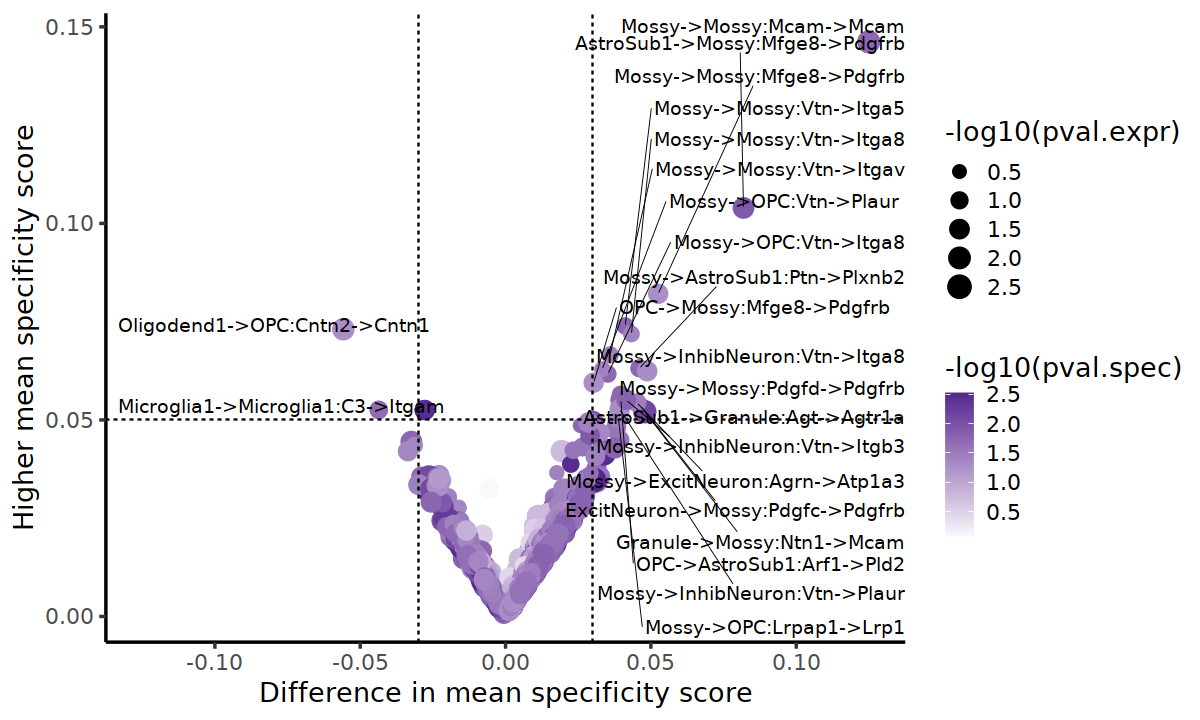

In [15]:
pval.th <- 0.05
spec.higher.th <- 0.05
spec.higher.th2 <- spec.higher.th/2
spec.diff.th <- 0.03

p0 <- joined %>%
    filter(sign(logfc) == sign(diff)) %>%
    #filter(mean.1 > spec.higher.th2 | mean.2 > spec.higher.th2) %>%
    mutate(frac.ligand.higher = ifelse(logfc > 0, frac.ligand.1, frac.ligand.2), frac.receptor.higher = ifelse(logfc > 0, frac.receptor.1, frac.receptor.2)) %>%
    filter(frac.ligand.higher > 0.1, frac.receptor.higher > 0.1) %>%
    filter(pval.expr < pval.th | pval.spec < pval.th) %>%
    mutate(spec.higher = ifelse(logfc > 0, mean.1, mean.2), expr.higher = ifelse(logfc > 0, logmean.1, logmean.2)) %>%
    mutate(label1 = ifelse(
        ((pval.expr < pval.th & abs(diff) > spec.diff.th & spec.higher > spec.higher.th) | (pval.spec < pval.th & abs(diff) > spec.diff.th & spec.higher > spec.higher.th)) & logfc < 0  , 
        paste0(Sending.cluster, "->", Target.cluster, ':', Ligand.symbol, "->", Receptor.symbol), "")) %>%
    mutate(label2 = ifelse(
        ((pval.expr < pval.th & abs(diff) > spec.diff.th & spec.higher > spec.higher.th) | (pval.spec < pval.th & abs(diff) > spec.diff.th & spec.higher > spec.higher.th)) & logfc > 0  , 
        paste0(Sending.cluster, "->", Target.cluster, ':', Ligand.symbol, "->", Receptor.symbol), "")) 

options(repr.plot.width = 10, repr.plot.height = 6)
p <- ggplot(p0, aes(x = diff, y = spec.higher, size = -log10(pval.expr))) +
    geom_point(aes(color = -log10(pval.spec))) + 
    scale_color_gradient2(low = "#cbc9e2", high = "#54278f") + 
    theme_classic(base_size = 16) +
    geom_text_repel(data = p0 %>% filter(label1 != ""), 
        aes(label = label1), 
        size = 4, 
        force = 10, 
        hjust = 1, 
        direction = 'y', 
        nudge_x = -0.1, 
        nudge_y = 0.001, 
        segment.size = 0.2, 
        max.overlaps = 100
    ) +
    geom_text_repel(data = p0 %>% filter(label2 != ""), 
        aes(label = label2), 
        size = 4, 
        force = 10, 
        hjust = 1, 
        direction = 'y', 
        nudge_x = 0.1, 
        nudge_y = 0.0055, 
        segment.size = 0.2, 
        max.overlaps = 100
    ) +
    geom_vline(aes(xintercept = spec.diff.th), linetype = 'dashed') +
    geom_vline(aes(xintercept = -spec.diff.th), linetype = 'dashed') +
    geom_hline(aes(yintercept = spec.higher.th), linetype = 'dashed') +
    lims(x = c(-0.125, 0.125)) +
    labs(x = 'Difference in mean specificity score', y = 'Higher mean specificity score')

ggsave(filename = "../processed_data/211116_natmi_figures/NATMI-dorDG.volcano.pdf", 
    plot = p, width = 10, height = 7.5)
p

## Plot top ligands

In [11]:
cts <- c('ExcitNeuron', 'InhibNeuron', 'Granule', 'Mossy', 
         'Oligodend1', 'Oligodend2', 'OPC', 'BergGlia', 
         'AstroSub1', 'Microglia1', 'Microglia2', 'Endothelial')

In [12]:
makeLogfc <- function(ligand, receptor){
    mat <- joined %>% filter(Ligand.symbol == ligand, Receptor.symbol == receptor) %>%
        select(Sending.cluster, Target.cluster, logfc) %>%
        pivot_wider(names_from = Target.cluster, values_from = logfc) %>%
        tibble::column_to_rownames("Sending.cluster")
    mat <- as.matrix(mat)
    mat <- mat[match(cts, row.names(mat)), match(cts, colnames(mat))]
    row.names(mat) <- cts
    colnames(mat) <- cts
    mat[is.na(mat)] <- 0
    return(mat)
}

makePvalExpr <- function(ligand, receptor){
    mat <- joined %>% filter(Ligand.symbol == ligand, Receptor.symbol == receptor) %>%
        select(Sending.cluster, Target.cluster, pval.expr) %>%
        pivot_wider(names_from = Target.cluster, values_from = pval.expr) %>%
        tibble::column_to_rownames("Sending.cluster")
    mat <- as.matrix(mat)
    mat <- mat[match(cts, row.names(mat)), match(cts, colnames(mat))]
    row.names(mat) <- cts
    colnames(mat) <- cts
    mat[is.na(mat)] <- 1
    return(mat)
}

makeDiff <- function(ligand, receptor){
    mat <- joined %>% filter(Ligand.symbol == ligand, Receptor.symbol == receptor) %>%
        select(Sending.cluster, Target.cluster, diff) %>%
        pivot_wider(names_from = Target.cluster, values_from = diff) %>%
        tibble::column_to_rownames("Sending.cluster")
    mat <- as.matrix(mat)
    mat <- mat[match(cts, row.names(mat)), match(cts, colnames(mat))]
    row.names(mat) <- cts
    colnames(mat) <- cts
    mat[is.na(mat)] <- 0
    return(mat)
}

makePvalSpec <- function(ligand, receptor){
    mat <- joined %>% filter(Ligand.symbol == ligand, Receptor.symbol == receptor) %>%
        select(Sending.cluster, Target.cluster, pval.spec) %>%
        pivot_wider(names_from = Target.cluster, values_from = pval.spec) %>%
        tibble::column_to_rownames("Sending.cluster")
    mat <- as.matrix(mat)
    mat <- mat[match(cts, row.names(mat)), match(cts, colnames(mat))]
    row.names(mat) <- cts
    colnames(mat) <- cts
    mat[is.na(mat)] <- 1
    return(mat)
}

makeFracFilter <- function(ligand, receptor){
    mat <- joined %>% filter(Ligand.symbol == ligand, Receptor.symbol == receptor) %>%
        mutate(frac.ligand.higher = ifelse(logfc > 0, frac.ligand.1, frac.ligand.2), frac.receptor.higher = ifelse(logfc > 0, frac.receptor.1, frac.receptor.2)) %>%
        mutate(frac.filter = frac.ligand.higher > 0.1 & frac.receptor.higher > 0.1) %>%
        select(Sending.cluster, Target.cluster, frac.filter) %>%
        pivot_wider(names_from = Target.cluster, values_from = frac.filter) %>%
        tibble::column_to_rownames("Sending.cluster")
    mat <- as.matrix(mat)
    mat <- mat[match(cts, row.names(mat)), match(cts, colnames(mat))]
    row.names(mat) <- cts
    colnames(mat) <- cts
    mat[is.na(mat)] <- F
    return(mat)
}

In [13]:
joined.f <- joined %>%
    filter(sign(logfc) == sign(diff)) %>%
    mutate(frac.ligand.higher = ifelse(logfc > 0, frac.ligand.1, frac.ligand.2), frac.receptor.higher = ifelse(logfc > 0, frac.receptor.1, frac.receptor.2)) %>%
    filter(frac.ligand.higher > 0.1, frac.receptor.higher > 0.1) %>%
    mutate(spec.higher = ifelse(logfc > 0, mean.1, mean.2), expr.higher = ifelse(logfc > 0, logmean.1, logmean.2), Treatment = ifelse(logfc > 0, 'FT', 'Sham')) %>%
    filter(abs(diff) > spec.diff.th & spec.higher > spec.higher.th) %>%    
    filter(pval.expr < pval.th | pval.spec < pval.th) %>%
    arrange(pval.expr)
top.lrs <- joined.f %>% distinct(Ligand.symbol, Receptor.symbol)
c(dim(joined.f), dim(top.lrs))

[1] 22 21 17  2

In [14]:
write.csv(joined.f, file = "../processed_data/211116_natmi_figures/NATMI-dorDG.top_hits.csv")

In [36]:
ligands <- top.lrs$Ligand.symbol[16:17]
receptors <- top.lrs$Receptor.symbol[16:17]
lrs <- paste0(ligands, '->', receptors)
lrs <- factor(rep(lrs, each = length(cts)), levels = lrs)

logfc <- do.call(rbind, mapply(makeLogfc, ligands, receptors, SIMPLIFY = F))
pval.expr <- -log10(do.call(rbind, mapply(makePvalExpr, ligands, receptors, SIMPLIFY = F)))
diff <- do.call(rbind, mapply(makeDiff, ligands, receptors, SIMPLIFY = F))
pval.spec <- -log10(do.call(rbind, mapply(makePvalSpec, ligands, receptors, SIMPLIFY = F)))
frac.filter <- do.call(rbind, mapply(makeFracFilter, ligands, receptors, SIMPLIFY = F))

cm <- cividis(3)

col_fun = colorRamp2(c(-2, 0, 2), cm)
hm.expr <- Heatmap(logfc, cluster_rows = F, cluster_columns = F, 
    cluster_row_slices = F, row_names_side = 'left', 
    cluster_column_slices = F, column_names_side = 'top',
    rect_gp = gpar(type = "none"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.rect(x = x, y = y, width = width, height = height, 
            gp = gpar(col = "lightgrey", fill = NA))        
        grid.circle(x = x, y = y, r = 0.5 * pval.expr[i,j]/2.5 * unit(5, "mm"), 
        gp = gpar(col = NA, fill = ifelse(frac.filter[i,j], col_fun(logfc[i,j]), 'white')))           
    },     
    height = unit(5, "mm") * length(lrs), 
    width = unit(5, "mm") * length(cts),                    
    col = col_fun, column_title = 'Log difference in\n mean expression score', 
    name = 'Log difference in\n mean expression score',
    row_split = lrs)

col_fun2 = colorRamp2(c(-0.02, 0, 0.02), cm)
hm.spec <- Heatmap(diff, cluster_rows = F, cluster_columns = F, 
    cluster_row_slices = F, row_names_side = 'left', 
    cluster_column_slices = F, column_names_side = 'top',
    rect_gp = gpar(type = "none"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.rect(x = x, y = y, width = width, height = height, 
            gp = gpar(col = "lightgrey", fill = NA))        
        grid.circle(x = x, y = y, r = 0.5 * pval.spec[i,j]/2.5 * unit(5, "mm"), 
        gp = gpar(col = NA, fill = ifelse(frac.filter[i,j], col_fun2(diff[i,j]), 'white')))           
    },      
    col = col_fun2, column_title = 'Difference in\n mean specificity score', 
    height = unit(5, "mm") * length(lrs), 
    width = unit(5, "mm") * length(cts),     
    name = 'Difference in\n mean specificity score',
    row_split = lrs
)

lgd <- Legend(labels = c(0.5, 1, 2),
           title = "-log10 p-value",
           graphics = list(
              function(x, y, w, h) grid.circle(x, y, 
                                               r=0.5 * 0.5/2.5 * unit(5, "mm"),
                                               gp=gpar(fill="black")),
              function(x, y, w, h) grid.circle(x, y, 
                                               r=0.5 * 1/2.5 * unit(5, "mm"),
                                               gp=gpar(fill="black")),
              function(x, y, w, h) grid.circle(x, y, 
                                               r=0.5 * 2/2.5 * unit(5, "mm"),
                                               gp=gpar(fill="black"))
           ))

ht_list <- hm.expr + hm.spec

pdf(file = "../processed_data/211116_natmi_figures/NATMI-dorDG.dotplot-4.pdf",
    width = 10, height = 15)
draw(ht_list, ht_gap = unit(5, "mm"), row_gap = unit(5, "mm"), 
     merge_legend = T, annotation_legend_list = list(lgd), 
     row_title = 'Sender', column_title = '               Receiver', 
     column_title_gp = gpar(fontsize = 16), row_title_gp = gpar(fontsize = 16))
dev.off()

png 
  2